# AIPI 590 - XAI | Assignment #06
### Human-AI Interaction: GradCAM Code Walkthrough
### Rebecca Du (rrd17)



[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rrdu/AIPI-590/blob/main/HW6/AIPI590_HumanAI_Interaction.ipynb)


## Overview

This notebook will do a simple code tutorial on how to implement **GradCAM**

Table of Contents:

1. What is GradCAM?
2. Task & Model Selection
3. Preprocessing
4. Load Model & Select Target Layer
5. Get Gradients
6. Forward & Backward Passes
7. Calculate GradCAM Heatmap
8. Upsampling & Overlay
9. Explanation

## 1) What is GradCAM?

**GradCAM** (Gradient-Weighted Class Activation Mapping) is an Explainable AI technique that visualizes what parts of an input a model "looks at" when making its prediction.

It works with CNNs (Convolutional Neural Networks).

[This presentation](https://docs.google.com/presentation/d/1YBLmbRunuvhWI3CAUv2s47zjgZJ2JbhxhoZ2bu11toE/edit?usp=sharing) goes more into detail regarding the math behind GradCAM.

## 2) Task & Model Selection

First, we must choose a task and a model to use GradCAM on.

Let's define them as follows:
- **Task:** Image classification
- **Model:** ResNet50 (pretrained on ImageNet)

For our task, we will use this image:

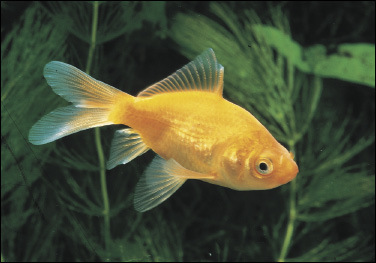

## 3) Preprocessing

Since ResNet50 was trained on ImageNet, we need to make some adjustments to the picture to make sure the model can be properly applied to it.

First, let's install/import some necessary tools and load in our image.

In [23]:
#Imports

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models, transforms
from PIL import Image
from google.colab import files

In [24]:
#Load image
img = files.upload()

Saving goldfish.JPEG to goldfish (1).JPEG


In [25]:
#Preprocess image into ImageNet format
#The code in this cell was generated using GPT-5 on 10/10/2025 at 3:50 PM
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [26]:
#Apply preprocessing
img_pil = Image.open('goldfish.JPEG')
img_tensor = preprocess(img_pil).unsqueeze(0)

#Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_tensor = img_tensor.to(device)

## 4) Load Model & Select Target Layer

Now we can load in our ResNet50 model.

We also need to select the target layer that GradCAM will be applied to. Typically, this is the last convolutional block, which we will pick in this demonstration.

In [28]:
#Load ResNet50 model
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights).to(device)

In [29]:
#Get class labels
class_names = weights.meta['categories']

In [30]:
#Set model to evaluation mode to process our image
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
#Select last convolutional layer as target
target_layer = model.layer4[-1].conv3

## 5) Get Gradients

For GradCAM, we need 2 things:
- **Feature maps** (output activations)
  - Obtained during forward pass
- **Model output gradients**
  - Obtained during backward pass/backpropagation

To get these values, we will use **hooks** - simple functions that will run automatically during the passes and save those values we want.

Let's define the hooks now.

In [32]:
#Initialize arrays for values
activations = []
gradients = []

#Make hook functions
def forward_hook(module, input, output):
  '''Stores the output activations'''
  activations.append(output.detach())

def backward_hook(module, grad_in, grad_out):
  '''Stores the model output gradients'''
  gradients.append(grad_out[0].detach())

In [33]:
#Attach hooks to our target layer
f_hook = target_layer.register_forward_hook(forward_hook)
b_hook = target_layer.register_full_backward_hook(backward_hook)

## 6) Forward & Backward Passes

Now, we need to perform the forward pass and backward pass (backpropagation) so that our hooks can get the activations and gradients we need for GradCAM.

In [34]:
#Get class name
with torch.no_grad():
  logits = model(img_tensor)
  pred_index = logits.argmax(dim=1).item()

pred_class_name = class_names[pred_index]
print('Predicted class: ', pred_class_name)

Predicted class:  goldfish


Looks like ResNet50 was able to correctly label the class!

In [41]:
#Forward pass
model.zero_grad()
activations.clear()
gradients.clear()

logits = model(img_tensor)
prediction = logits.argmax(dim=1).item()

In [42]:
#Backward pass
class_score = logits[0, prediction]
class_score.backward()

In [43]:
#Get activations and gradients
A = activations[-1]
G = gradients[-1]

## 7) Calculate GradCAM Heatmap

Here is where we turn all those values into GradCAM.

Mathematically, we:
- Get the mean of the gradients
- Multiply the mean by the activations to give them appropriate weights
- Add all the weighted activations together
- Apply ReLU so we only focus on parts of the image that help the model classify the image

In [44]:
#Get weights
weights = G.mean(dim=(2,3), keepdim=True)

#Weight activations
gradcam = (weights * A).sum(dim=1, keepdim=True)

#Apply ReLU
gradcam = F.relu(gradcam)

In [45]:
#Normalize
gradcam -= gradcam.min()
gradcam /= gradcam.max()

## 8) Upsampling & Overlay

Lastly, to see the output of GradCAM on our original image, we need to do 2 steps:
1) **Upsampling** to scale the image back to the original size
2) **Overlay** our GradCAM heatmap over the original image

In [46]:
#Upsample to (224, 224) (ResNet50 input size)
gradcam_upsample = F.interpolate(
    gradcam,
    size = (224, 224),
    mode = 'bilinear',
    align_corners = False
)

gradcam_upsample = gradcam_upsample[0,0].cpu().numpy()

In [47]:
#Make original image displayable
#Code in this cell was generated using GPT-5 on 10/10/2025 at 4:10 PM
displayable = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

img_display = np.array(displayable(img_pil))

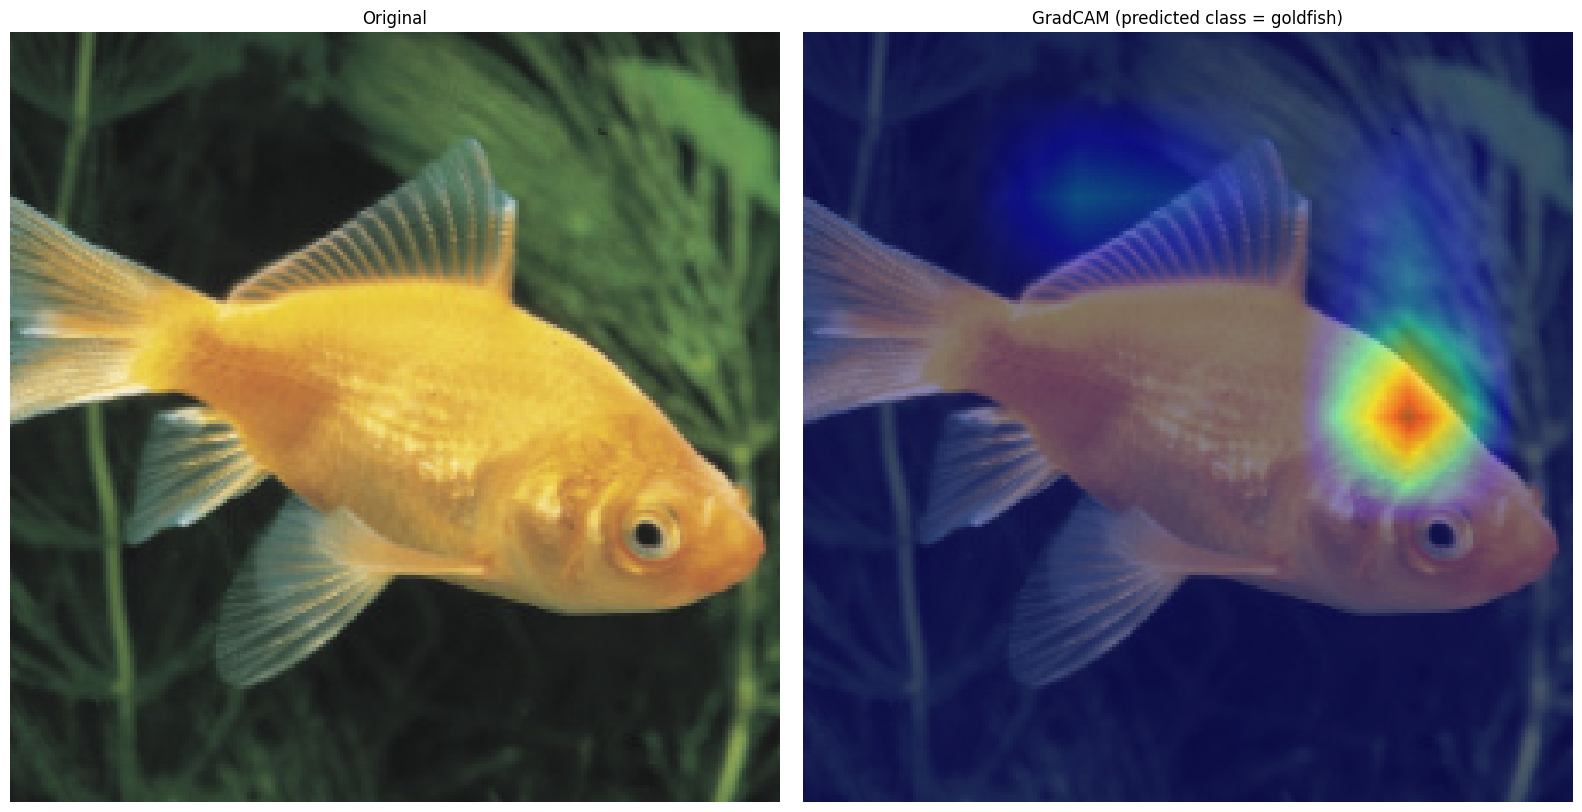

In [50]:
#Overlay and view image
plt.figure(figsize=(16, 8))

#Original image
plt.subplot(1,2,1)
plt.title('Original')
plt.axis('off')
plt.imshow(img_display)

#GradCAM overlay
plt.subplot(1,2,2)
plt.title(f'GradCAM (predicted class = {pred_class_name})')
plt.axis('off')
plt.imshow(img_display)
plt.imshow(gradcam_upsample, cmap='jet', alpha=0.45)
plt.tight_layout()
plt.show()

## 9) Explanation

From the image above, we can see that according to GradCAM, ResNet50 mostly looked at the goldfish's head to label the class. Interestingly, it only looked at a very small area to come to this conclusion.